In [1]:
# Inspecting a CSV file using pandas
import pandas as pd

urldata= pd.read_csv('../data/raw/urldata.csv')
urldata.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [2]:
# Removing the Unnamed column (run only once)
urldata= urldata.drop("Unnamed: 0", axis=1)
urldata.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


In [3]:
# Checking for missing values
urldata.isnull().sum()

url       0
label     0
result    0
dtype: int64

In [4]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   label   450176 non-null  object
 2   result  450176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


# Data Preprocessing
## 1. Handling Missing Values & Removing Duplicates

In [5]:
import numpy as np

urldata["url"] = urldata["url"].replace("", np.nan)

# Drop rows with missing URL or label
before_missing = len(urldata)
urldata = urldata.dropna(subset=["url", "label"])
after_missing = len(urldata)
print(f"Removed {before_missing - after_missing} rows due to missing URL or label.")

# Drop duplicate rows
before_dupes = len(urldata)
urldata = urldata.drop_duplicates()
after_dupes = len(urldata)
print(f"Removed {before_dupes - after_dupes} duplicate rows.")

Removed 0 rows due to missing URL or label.
Removed 0 duplicate rows.


In [6]:
# Normalizing URLs before parsing
def normalize_url(url):
    if not isinstance(url, str):
        return ''
    url= url.strip()
    url= url.replace("[.]", ".") # Replace obfuscated dots
    if not url.startswith(('http://', 'https://')): # Add scheme if missing
        url= 'http://' + url
    return url

## 2. Canonicalization
- Lowercasing all URLs
- Removing everything after "#"
- Stripping default ports (:80,:443)
- Prepending "http://"
- Trimming whitespace

In [7]:
# Basic URL canonicalization
urldata["url"] = (
    urldata["url"]
        .astype(str)   # ensure it's a string
        .str.strip()   # remove leading/trailing whitespace
        .str.lower()   # normalize case
        .str.split("#").str[0]  # remove URL fragments after '#'
)

# Strip default ports (:80, :443)
urldata["url"] = urldata["url"].str.replace(":80/", "/", regex=False)
urldata["url"] = urldata["url"].str.replace(":443/", "/", regex=False)
urldata["url"] = urldata["url"].str.replace(":80", "", regex=False)
urldata["url"] = urldata["url"].str.replace(":443", "", regex=False)

# If scheme is missing, prepend 'http://' 
mask_missing_scheme = ~urldata["url"].str.match(r'^[a-z][a-z0-9+.+-]*://', na=False)
urldata.loc[mask_missing_scheme, "url"] = "http://" + urldata.loc[mask_missing_scheme, "url"]


## 3. Feature Extraction
#### 1. Lengths
- URL Length
- Hostname Length
- Path Length
- Fist Directory Length
- Top Level Domain Length
- Query Length

In [8]:
from urllib.parse import urlparse
from tld import get_tld

# URL Length
urldata["url_length"]= urldata["url"].apply(lambda x: len(str(x)))

# Hostname Length
def hostname_length(url):
    url= normalize_url(url)
    parsed= urlparse(url)
    return len(parsed.hostname or '')
urldata["hostname_length"]= urldata["url"].apply(hostname_length)

# Path Length
def path_length(url):
    url= normalize_url(url)
    parsed= urlparse(url)
    return len(parsed.path)
urldata["path_length"]= urldata["url"].apply(path_length)

# First Directory Length
def first_directory_length(url):
    url= normalize_url(url)
    path= urlparse(url).path
    first_directory= path.split('/')[1] if len(path.split('/')) > 1 else ''
    return len(first_directory)
urldata["first_directory_length"]= urldata["url"].apply(first_directory_length)

# Top Level Domain Length
def tld_length(url):
    url= normalize_url(url)
    try:
        tld= get_tld(url, fail_silently=True)
        return len(tld) if tld else 0
    except:
        return 0
urldata["tld_length"]= urldata["url"].apply(tld_length)

# Query Length
def query_length(url):
    url= normalize_url(url)
    parsed= urlparse(url)
    return len(parsed.query)
urldata["query_length"]= urldata["url"].apply(query_length)

urldata.head()

,url,label,result,url_length,hostname_length,path_length,first_directory_length,tld_length,query_length
0,https://www.google.com,benign,0,22,14,0,0,3,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0


#### 2. Counts
- Special Characters
    - !@#$%^&*()-_=+[]{}|;:'\",.<>?/\\`~
- Count Of 'www'
- Count Of Digits
- Count Of Letters
- Count Of Number Of Directories
- Count Of Number Of Subdomains
- Count Of Tokens In URL

In [9]:
import tldextract

def special_char_count(url):
    url= str(url)
    special_chars= "!@#$%^&*()-_=+[]{}|;:'\",.<>?/\\`~"
    count= sum(1 for c in url if c in special_chars)
    return count
urldata["special_char_count"]= urldata["url"].apply(special_char_count)

urldata["count-www"]= urldata["url"].apply(lambda x: str(x).count('www'))

# Digit Count
def digit_count(url):
    url= str(url)
    digits= sum(c.isdigit() for c in url)
    return digits
urldata["digit_count"]= urldata["url"].apply(digit_count)

# Letter Count
def letter_count(url):
    url= str(url)
    letters= sum(c.isalpha() for c in url)
    return letters
urldata["letter_count"]= urldata["url"].apply(letter_count)

# Directory Count
def dir_count(url):
    url= normalize_url(url)
    dir= urlparse(url).path
    return dir.count('/')
urldata["dir_count"]= urldata["url"].apply(dir_count)

# Subdomain Count
def subdomain_count(url):
    url= normalize_url(url)
    hostname= urlparse(url).hostname or ''
    ext= tldextract.extract(hostname)
    if not ext.subdomain:
        return 0
    return len(ext.subdomain.split('.'))
urldata["subdomain_count"]= urldata["url"].apply(subdomain_count)

# Query Parameter Count
def query_param_count(url):
    url= normalize_url(url)
    parsed= urlparse(url)
    query= parsed.query
    if query:
        return query.count('&') + 1
    return 0
urldata["query_param_count"]= urldata["url"].apply(query_param_count)

urldata.head()

,url,label,result,url_length,hostname_length,path_length,first_directory_length,tld_length,query_length,special_char_count,count-www,digit_count,letter_count,dir_count,subdomain_count,query_param_count
0,https://www.google.com,benign,0,22,14,0,0,3,0,5,1,0,17,0,1,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,5,1,0,18,0,1,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,5,1,0,19,0,1,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,5,1,0,16,0,1,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,5,1,0,20,0,1,0


#### 3. Binary Features
- Has IP
- Uses HTTPS
- Has Suspicious Extension
- Uses Shortener

In [10]:
import re
import ipaddress

# Has IP Address
def has_ip_address(url):
    url= normalize_url(url)
    host= urlparse(url).hostname or ''
    try:
        ipaddress.ip_address(host)
        return 1
    except ValueError:
        return 0
urldata["has_ip_address"]= urldata["url"].apply(has_ip_address)

# Uses HTTPS
def uses_https(url):
    url= normalize_url(url)
    return 1 if urlparse(url).scheme== 'https' else 0
urldata["uses_https"]= urldata["url"].apply(uses_https)

# Has Suspicious Extension
def suspicious_extension(url):
    url= normalize_url(url)
    suspicious_exts= ['.exe', '.zip', '.rar', '.scr', '.pif', '.bat', '.cmd', '.js', '.vbs']
    path= urlparse(url).path
    for ext in suspicious_exts:
        if path.endswith(ext):
            return 1
    return 0
urldata["suspicious_extension"]= urldata["url"].apply(suspicious_extension)

# Uses Shortening
shortening_services= re.compile( 
    r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|ow\.ly|t\.co|tinyurl|is\.gd|cli\.gs|' 
    r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' 
    r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' 
    r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|lnkd\.in|' 
    r'db\.tt|qr\.ae|adf\.ly|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|ity\.im|' 
    r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' 
    r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' 
    r'tr\.im|link\.zip\.net' 
    , re.IGNORECASE               # added this flag becuase we're casting to lower case in uses_shortening
)

def uses_shortening(url): 
    url= normalize_url(url) 
    hostname= (urlparse(url).hostname or '')
    return 1 if shortening_services.search(hostname) else 0
urldata["uses_shortening"]= urldata["url"].apply(uses_shortening)

urldata.head()

,url,label,result,url_length,hostname_length,path_length,first_directory_length,tld_length,query_length,special_char_count,count-www,digit_count,letter_count,dir_count,subdomain_count,query_param_count,has_ip_address,uses_https,suspicious_extension,uses_shortening
0,https://www.google.com,benign,0,22,14,0,0,3,0,5,1,0,17,0,1,0,0,1,0,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,5,1,0,18,0,1,0,0,1,0,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,5,1,0,19,0,1,0,0,1,0,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,5,1,0,16,0,1,0,0,1,0,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,5,1,0,20,0,1,0,0,1,0,0


#### 4. Entropy
- Shannon Entropy

In [11]:
# Shannon Entropy
import math
def shannon_entropy(url):
    url= str(url)
    if not url:
        return 0
    freq= {}
    for char in url:
        freq[char]= freq.get(char, 0) + 1
    entropy= 0.0
    length= len(url)
    for char, count in freq.items():
        p= count / length
        entropy -= p * math.log2(p)
    return entropy
urldata["shannon_entropy"]= urldata["url"].apply(shannon_entropy)

urldata.head()

,url,label,result,url_length,hostname_length,path_length,first_directory_length,tld_length,query_length,special_char_count,...,digit_count,letter_count,dir_count,subdomain_count,query_param_count,has_ip_address,uses_https,suspicious_extension,uses_shortening,shannon_entropy
0,https://www.google.com,benign,0,22,14,0,0,3,0,5,...,0,17,0,1,0,0,1,0,0,3.663533
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,5,...,0,18,0,1,0,0,1,0,0,3.762267
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,5,...,0,19,0,1,0,0,1,0,0,3.855389
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,5,...,0,16,0,1,0,0,1,0,0,3.880180
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,5,...,0,20,0,1,0,0,1,0,0,3.813661


#### 5. Ratios
- Digit Ratio
- Letter Ratio
- Special Character Ratio

In [12]:
# Digit Ratio
def digit_ratio(url):
    url= str(url)
    digits= sum(c.isdigit() for c in url)
    length= len(url)
    return digits / length if length > 0 else 0
urldata["digit_ratio"]= urldata["url"].apply(digit_ratio)

# Letter Ratio
def letter_ratio(url):
    url= str(url)
    letters= sum(c.isalpha() for c in url)
    length= len(url)
    return letters / length if length > 0 else 0
urldata["letter_ratio"]= urldata["url"].apply(letter_ratio)

# Special Character Ratio
def special_char_ratio(url):
    url= str(url)
    special_chars= "!@#$%^&*()-_=+[]{}|;:'\",.<>?/\\`~"
    special_count= sum(1 for c in url if c in special_chars)
    length= len(url)
    return special_count / length if length > 0 else 0
urldata["special_char_ratio"]= urldata["url"].apply(special_char_ratio)

urldata.head().T

,0,1,2,3,4
url,https://www.google.com,https://www.youtube.com,https://www.facebook.com,https://www.baidu.com,https://www.wikipedia.org
label,benign,benign,benign,benign,benign
result,0,0,0,0,0
url_length,22,23,24,21,25
hostname_length,14,15,16,13,17
path_length,0,0,0,0,0
first_directory_length,0,0,0,0,0
tld_length,3,3,3,3,3
query_length,0,0,0,0,0
special_char_count,5,5,5,5,5


## 4. Splittting

In [13]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
X= urldata.drop(columns=["url", "label", "result"]) # Features
y= urldata["label"]

print(X.columns)

y_binary= (urldata["label"]== 'malicious').astype(int)

# Split is 80% train, 20% test
X_train, X_test, y_train, y_test= train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

Index(['url_length', 'hostname_length', 'path_length',
       'first_directory_length', 'tld_length', 'query_length',
       'special_char_count', 'count-www', 'digit_count', 'letter_count',
       'dir_count', 'subdomain_count', 'query_param_count', 'has_ip_address',
       'uses_https', 'suspicious_extension', 'uses_shortening',
       'shannon_entropy', 'digit_ratio', 'letter_ratio', 'special_char_ratio'],
      dtype='object')


## 5. Imbalance and Scaling

In [14]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

train_counts= pd.Series(y_train).value_counts()
imbalance_ratio= train_counts.max() / train_counts.min()
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("Undersampling to balance classes")

    train_data= X_train.copy()
    train_data['target']= y_train.values

    benign_data= train_data[train_data['target']== 0]
    malicious_data= train_data[train_data['target']== 1]

    print(f"Original - Benign: {len(benign_data):,}, Malicious: {len(malicious_data):,}")

    # Undersample majority class (benign) to 1.2x malicious
    target_benign_size= int(len(malicious_data) * 1.2)

    benign_downsampled= resample(benign_data,
                                   replace=False,
                                   n_samples=target_benign_size,
                                   random_state=42)

    # Combine and shuffle
    train_balanced= pd.concat([benign_downsampled, malicious_data])
    train_balanced= train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split back
    X_train_balanced= train_balanced[X.columns.to_list()]
    y_train_balanced= train_balanced['target'].values

    print(f"\nBalanced training set size: {X_train_balanced.shape}")
    print("New class distribution:")
    new_dist= pd.Series(y_train_balanced).value_counts()
    print(f"  Benign (0): {new_dist[0]:,} ({new_dist[0]/len(y_train_balanced)*100:.1f}%)")
    print(f"  Malicious (1): {new_dist[1]:,} ({new_dist[1]/len(y_train_balanced)*100:.1f}%)")
    print(f"New imbalance ratio: {new_dist.max() / new_dist.min():.2f}")
else:
    print("\nClasses are reasonably balanced. No resampling needed.")
    X_train_balanced= X_train.copy()   # kept as DataFrame
    y_train_balanced= y_train.values

# Fit scaler on training data & transform both training and testing data
scaler= StandardScaler()
scaler.fit(X_train_balanced)

X_train_scaled= scaler.transform(X_train_balanced)
X_test_scaled= scaler.transform(X_test)

X_train_scaled= pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_balanced.index)
X_test_scaled= pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

Imbalance ratio: 3.31
Undersampling to balance classes
Original - Benign: 276,590, Malicious: 83,550

Balanced training set size: (183810, 21)
New class distribution:
  Benign (0): 100,260 (54.5%)
  Malicious (1): 83,550 (45.5%)
New imbalance ratio: 1.20


# Evaluation

In [15]:
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

def evaluate_model(
    model_name,
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    y_test_proba,
    train_time=None,
    best_params=None,
    best_cv_f1=None,
):
    print(f"\n{'=' * 70}")
    print(model_name)
    print(f"{'=' * 70}")

    # Hyperparameter / timing info
    if best_params is not None or best_cv_f1 is not None or train_time is not None:
        print("\nHyperparameter Tuning Summary:")
        if best_params is not None:
            print(f"  Best params: {best_params}")
        if best_cv_f1 is not None:
            print(f"  Best CV F1: {best_cv_f1:.6f}")
        if train_time is not None:
            print(f"  Training time (tuning + fit): {train_time:.2f} seconds")

    # Train vs test accuracy (for overfitting check)
    train_acc= accuracy_score(y_train, y_train_pred)
    test_acc= accuracy_score(y_test, y_test_pred)

    # Test-set metrics
    accuracy= test_acc
    precision= precision_score(y_test, y_test_pred)
    recall= recall_score(y_test, y_test_pred)
    f1= f1_score(y_test, y_test_pred)

    print(f"\nPerformance Metrics (Test Set):")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score:  {f1:.4f}")

    print(f"\nTrain vs Test Accuracy:")
    print(f"  Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Test  Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

    # Confusion matrix on test
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\nConfusion Matrix (Test Set):")
    print(f"                     Predicted")
    print(f"                Benign    Malicious")
    print(f"Actual Benign     {cm[0][0]:7,}   {cm[0][1]:7,}")
    print(f"       Malicious  {cm[1][0]:7,}   {cm[1][1]:7,}")

    # ROC-AUC on test
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    # Return everything for downstream plots/tables
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm,
        "fpr": fpr,
        "tpr": tpr,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "train_time": train_time,
        "best_params": best_params,
        "best_cv_f1": best_cv_f1,
    }

# SVM (Linear)

In [16]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time

cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
svm_param_grid= {
    'C': [0.01, 0.1, 1.0, 10.0],
}
svm_base_model= LinearSVC(max_iter=5000, random_state=42)

start_time= time.time()
svm_grid= GridSearchCV(estimator=svm_base_model,
                            param_grid=svm_param_grid,
                            scoring='f1',
                            cv=cv,
                            n_jobs=-1,
                            verbose=1)
svm_grid.fit(X_train_scaled, y_train_balanced)
svm_train_time= time.time() - start_time

best_svm= svm_grid.best_estimator_
y_pred_svm= best_svm.predict(X_test_scaled)
y_pred_proba_svm= best_svm.decision_function(X_test_scaled)
train_pred_svm= best_svm.predict(X_train_scaled)

svm_results= evaluate_model(
    model_name="Support Vector Machine (SVM) Model",
    y_train=y_train_balanced,
    y_train_pred=train_pred_svm,
    y_test=y_test,
    y_test_pred=y_pred_svm,
    y_test_proba=y_pred_proba_svm,
    train_time=svm_train_time,
    best_params=svm_grid.best_params_,
    best_cv_f1=svm_grid.best_score_,
)

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Support Vector Machine (SVM) Model

Hyperparameter Tuning Summary:
  Best params: {'C': 0.01}
  Best CV F1: 0.994508
  Training time (tuning + fit): 9.74 seconds

Performance Metrics (Test Set):
  Accuracy:  0.9964 (99.64%)
  Precision: 0.9927 (99.27%)
  Recall:    0.9916 (99.16%)
  F1-Score:  0.9921

Train vs Test Accuracy:
  Train Accuracy: 0.9950 (99.50%)
  Test  Accuracy: 0.9964 (99.64%)

Confusion Matrix (Test Set):
                     Predicted
                Benign    Malicious
Actual Benign      68,996       152
       Malicious      176    20,712

ROC-AUC Score: 0.9975


# Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

lr_param_grid= {
    'C': [0.01, 0.1, 1.0, 10.0],
}

lr_base_model= LogisticRegression(max_iter=5000, solver="liblinear", random_state=42)

start_time= time.time()
lr_grid= GridSearchCV(estimator=lr_base_model,
                            param_grid=lr_param_grid,
                            scoring='f1',
                            cv=cv,
                            n_jobs=-1,
                            verbose=1)
lr_grid.fit(X_train_scaled, y_train_balanced)
lr_train_time= time.time() - start_time

best_lr= lr_grid.best_estimator_
y_pred_lr= best_lr.predict(X_test_scaled)
y_pred_proba_lr= best_lr.predict_proba(X_test_scaled)[:, 1]
train_pred_lr= best_lr.predict(X_train_scaled)

lr_results= evaluate_model(
    model_name="Logistic Regression",
    y_train=y_train_balanced,
    y_train_pred=train_pred_lr,
    y_test=y_test,
    y_test_pred=y_pred_lr,
    y_test_proba=y_pred_proba_lr,
    train_time=lr_train_time,
    best_params=lr_grid.best_params_,
    best_cv_f1=lr_grid.best_score_,
)

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Logistic Regression

Hyperparameter Tuning Summary:
  Best params: {'C': 1.0}
  Best CV F1: 0.994539
  Training time (tuning + fit): 8.75 seconds

Performance Metrics (Test Set):
  Accuracy:  0.9964 (99.64%)
  Precision: 0.9927 (99.27%)
  Recall:    0.9916 (99.16%)
  F1-Score:  0.9921

Train vs Test Accuracy:
  Train Accuracy: 0.9951 (99.51%)
  Test  Accuracy: 0.9964 (99.64%)

Confusion Matrix (Test Set):
                     Predicted
                Benign    Malicious
Actual Benign      68,996       152
       Malicious      176    20,712

ROC-AUC Score: 0.9974


# XGBoost

In [18]:
from xgboost import XGBClassifier

xgb_param_grid= {
    'n_estimators': [200, 400],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
}

xgb_base_model= XGBClassifier(random_state=42, 
                              eval_metric='logloss', 
                              n_jobs=1, 
                              tree_method='hist')

start_time= time.time()
xgb_grid= GridSearchCV(estimator=xgb_base_model,
                             param_grid=xgb_param_grid,
                             scoring='f1',
                             cv=cv,
                             n_jobs=1,
                             verbose=1)
xgb_grid.fit(X_train_scaled, y_train_balanced)
xgb_train_time= time.time() - start_time

best_xgb= xgb_grid.best_estimator_
y_pred_xgb= best_xgb.predict(X_test_scaled)
y_pred_proba_xgb= best_xgb.predict_proba(X_test_scaled)[:, 1]
train_pred_xgb= best_xgb.predict(X_train_scaled)

xgb_results= evaluate_model(
    model_name= "XGBoost Classifier",
    y_train=y_train_balanced,
    y_train_pred=train_pred_xgb,
    y_test=y_test,
    y_test_pred=y_pred_xgb,
    y_test_proba=y_pred_proba_xgb,
    train_time=xgb_train_time,
    best_params=xgb_grid.best_params_,
    best_cv_f1=xgb_grid.best_score_,
)

Fitting 3 folds for each of 8 candidates, totalling 24 fits

XGBoost Classifier

Hyperparameter Tuning Summary:
  Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400}
  Best CV F1: 0.995188
  Training time (tuning + fit): 49.78 seconds

Performance Metrics (Test Set):
  Accuracy:  0.9971 (99.71%)
  Precision: 0.9947 (99.47%)
  Recall:    0.9930 (99.30%)
  F1-Score:  0.9938

Train vs Test Accuracy:
  Train Accuracy: 0.9965 (99.65%)
  Test  Accuracy: 0.9971 (99.71%)

Confusion Matrix (Test Set):
                     Predicted
                Benign    Malicious
Actual Benign      69,037       111
       Malicious      147    20,741

ROC-AUC Score: 0.9992




Comparative Model Evaluation Results



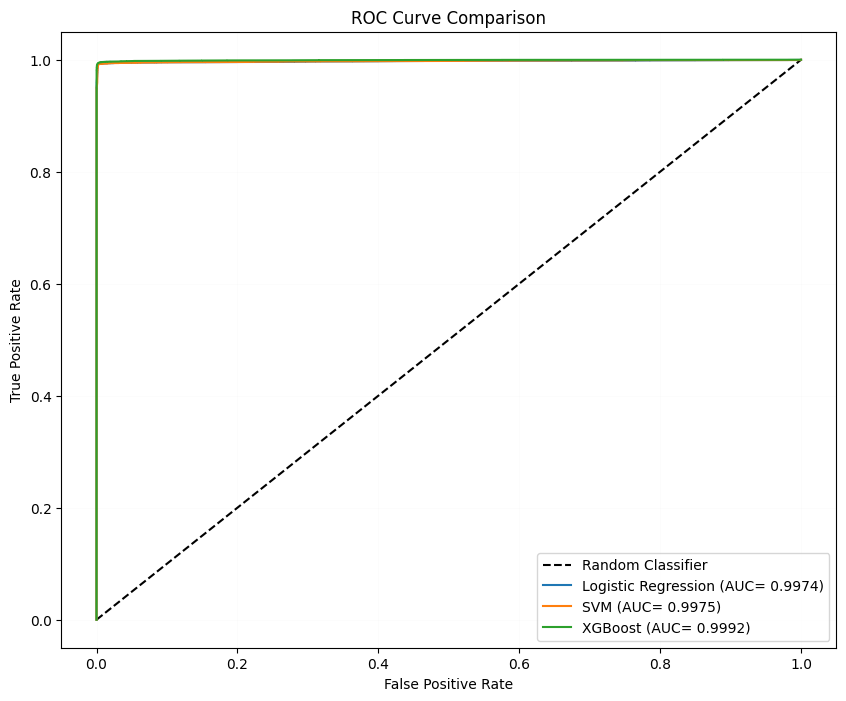

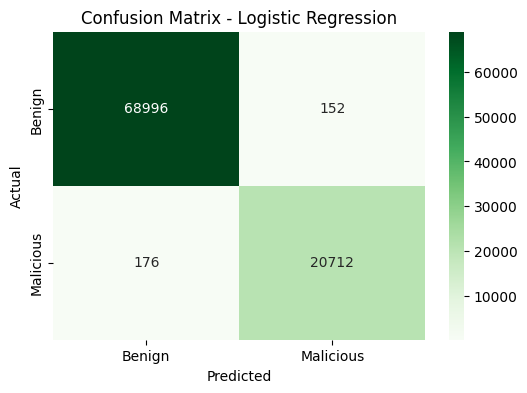

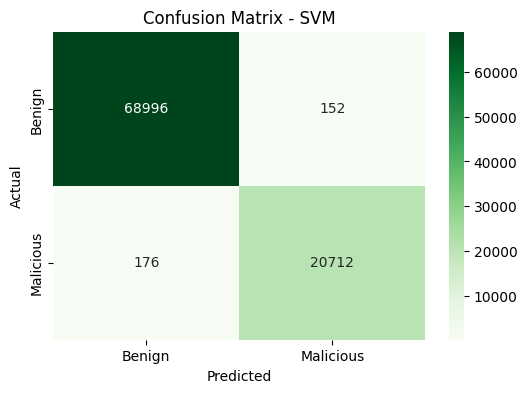

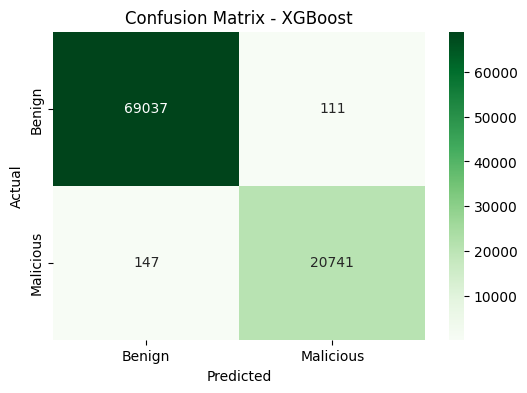

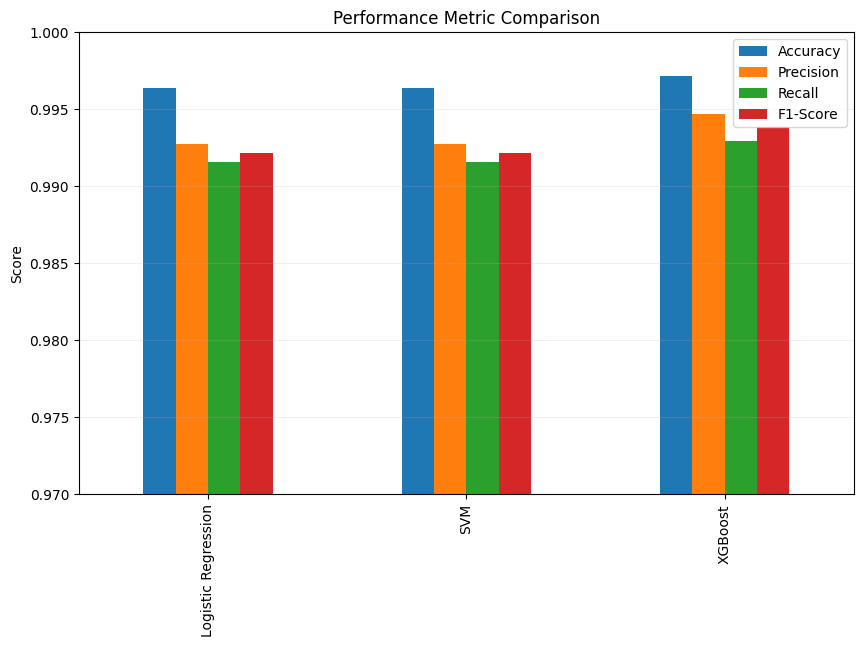

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n" + "=" * 70)
print("\nComparative Model Evaluation Results")
print("\n" + "=" * 70)

# Collect model results
all_results = {
    "Logistic Regression": lr_results,
    "SVM": svm_results,
    "XGBoost": xgb_results
}

# Build metrics_df internally (for bar graph)
metrics_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Training Time (s)"])

for model_name, results in all_results.items():
    if model_name == "Logistic Regression":
        train_time = lr_train_time
    elif model_name == "SVM":
        train_time = svm_train_time
    elif model_name == "XGBoost":
        train_time = xgb_train_time

    metrics_df.loc[model_name] = [
        results['accuracy'],
        results['precision'],
        results['recall'],
        results['f1'],
        results['roc_auc'],
        train_time
    ]

# ROC Curves
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

for model_name, results in all_results.items():
    plt.plot(results['fpr'], results['tpr'], label=f'{model_name} (AUC= {results["roc_auc"]:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.03)
plt.show()

# Confusion Matrices
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=["Benign", "Malicious"],
                yticklabels=["Benign", "Malicious"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix("Logistic Regression", y_test, y_pred_lr)
plot_confusion_matrix("SVM", y_test, y_pred_svm)
plot_confusion_matrix("XGBoost", y_test, y_pred_xgb)

# Bar Chart Comparison
metrics_plot_df= metrics_df[["Accuracy", "Precision", "Recall", "F1-Score"]].astype(float)
metrics_plot_df.plot(kind="bar", figsize=(10, 6))
plt.title("Performance Metric Comparison")
plt.ylabel("Score")
plt.ylim(0.97, 1.0)
plt.grid(axis="y", alpha=0.2)
plt.show()
